# Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
# TODO: seeding

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, SeparableConv1D, MaxPooling1D, Activation

Using TensorFlow backend.


# Read Data

In [2]:
x_train_df = pd.read_csv('x_train.csv', index_col=0)
x_test_df = pd.read_csv('x_test.csv', index_col=0)
y_train_series = pd.read_csv('y_train.csv', index_col=0, header=None)
y_test_series = pd.read_csv('y_test.csv', index_col=0, header=None)

# Just grab the values for training.
x_train = x_train_df.values
x_test = x_test_df.values
y_train = y_train_series.values
y_test = y_test_series.values
print('Data loaded.')

Data loaded.


# Constants for Reshaping

In [3]:
# How many weeks are we using for batches?
num_weeks = 4

# How many full weeks do we have?
five_min_per_week = int((1/5) * 60 * 24 * 7)
# Given the shape of our data, how many weeks are there? (round down)
weeks_train = np.floor(x_train.shape[0] / five_min_per_week).astype(int)
weeks_test = np.floor(x_test.shape[0] / five_min_per_week).astype(int)
# Given how many weeks we have and assuming we train with 4 week batches, how
# many batches will we have?
batches_train = int(np.floor(weeks_train) / num_weeks)
batches_test = int(np.floor(weeks_test) / num_weeks)
# Determine the ending index of the data we'll keep (trim off the end)
keep_train = five_min_per_week * batches_train
keep_test = five_min_per_week * batches_test
# Number of timesteps in a "month"
t_per_m = five_min_per_week * num_weeks
# Num features for convenience.
num_f = x_train.shape[1]

print('Constants for reshaping defined.')

Constants for reshaping defined.


# Reshape Data

In [4]:
# For the training data, we'll create 1000 "images" by randomly drawing starting positions.
np.random.seed(37)

def get_starting_indices(num_images, data_length, num_y):
    # Create array from 0 to the number of training samples minus one month minus the number of training samples
    start_arr = np.arange(start=0, stop=data_length - t_per_m - num_y, dtype=int)

    return np.random.choice(start_arr, size=num_images, replace=False)

In [5]:
# Reshape the data!
def reshape_xy(x_in, y_in, num_y, s):
    """
    x_in: x data
    y_in: y data
    num_y: number of y samples we'll be predicting. E.g., 12 to predict for 1 hour.
    s: array of starting indices.
    """
    # Arrange data so we have (batch, height, width, channels).
    x_out = np.zeros((len(s), num_weeks, five_min_per_week, x_in.shape[1]))
    
    # We'll predict some numbers of samples.
    y_out = np.zeros((len(s), num_y))
    
    # Loop over each starting index.
    for i, s_idx in enumerate(s):
        # Compute ending index.
        e_idx = s_idx + t_per_m
        
        # Loop over the features.
        for f in range(x_in.shape[1]):
            # Extract data.
            d = x_in[s_idx:e_idx, f]
            
            # Reshape it.
            d_r = np.reshape(d, newshape=(num_weeks, five_min_per_week))
            
            # Dump it into the reshaped x array.
            x_out[i, :, :, f] = d_r
            
        # Extract the approprate y data.
        y_out[i, :] = y_in[e_idx:e_idx + num_y].ravel()
    
    # All done.
    return x_out, y_out
            

# Get our train and test "images"
num_y=12
train_start = get_starting_indices(num_images=10000, data_length=x_train.shape[0], num_y=num_y)
x_train_reshaped, y_train_reshaped = reshape_xy(x_in=x_train, y_in=y_train,
                                                num_y=num_y, s=train_start)

test_start = get_starting_indices(num_images=100, data_length=x_test.shape[0], num_y=num_y)
x_test_reshaped, y_test_reshaped = reshape_xy(x_in=x_test, y_in=y_test,
                                              num_y=num_y, s=test_start)

print('Data reshaped.')

Data reshaped.


In [6]:
# print(train_start.shape)
# print(train_start[0:5])
# print(x_train_reshaped[0, :, :, 0])
# print('')
# print(x_train_reshaped[500, :, :, 0])

# Create and Train 2D CNN

In [7]:
# If training is taking too long, we may want to switch to 'SeperableConv2D'
# layers instead of simply Conv2D
model = Sequential()
# kernel size of 12, 4 will give us 12 5 minutes intervals and 4 weeks if the 
# data is arranged in a weekly format.
# 
# Using strides of 3, 1 so we traverse 15 minutes of data at a time.
input_shape = (num_weeks, five_min_per_week, x_train.shape[1])
print('Input shape: {}'.format(input_shape))
model.add(Conv2D(filters=16, kernel_size=(2, 36), strides=1,
                 padding='same', data_format='channels_last',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D((1, 12)))
model.add(Conv2D(filters=16, kernel_size=(2, 3), strides=1,
                 padding='same', data_format='channels_last'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 12)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train_reshaped.shape[1], activation='relu'))

model.compile(loss=keras.losses.mean_squared_error, optimizer='Adam',
              metrics=['mse'])
print(model.summary())

model.fit(x_train_reshaped, y_train_reshaped, epochs=3, shuffle=True, validation_split=0.2)

Input shape: (4, 2016, 18)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 2016, 16)       20752     
_________________________________________________________________
activation_1 (Activation)    (None, 4, 2016, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 168, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 168, 16)        1552      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 168, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 14, 16)         0         
___________________________________________

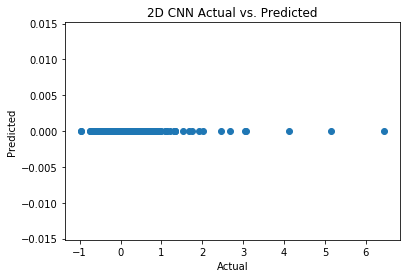

In [8]:
y_pred = model.predict(x_test_reshaped)

# TODO: Move this import - inline imports are poor form.
plt.scatter(y_test_reshaped.flatten(), y_pred.flatten())
# If our predictions were perfect, they'd fall exactly on this line.
# plt.plot([-20, 50], [-20,50])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('2D CNN Actual vs. Predicted')
plt.show()